# 2IIG0: Data Mining and Machine Learning

### HW 2 - Group 21

Riva Mendoza 1517635 <br>
Adrian Vramulet 1284487 <br>
Joe Yu 1520466 <br>

In [1]:
import numpy as np
import sys
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics.cluster import normalized_mutual_info_score
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import random as ran
from numpy import random
from matplotlib.font_manager import FontProperties
import timeit

fontP = FontProperties()
fontP.set_size('small')

## 1. K-means Clustering

In [29]:
def k_means(r, D, init, dist):
    X = initCentroids(D, r, init, dist)
    stop = False  
    
    X_hist = []
    X_hist.append(X)
    
    print("Running", end = '')

    while not stop:
        print(".", end = '')
        
        # assigns data points to centroids
        Y = clusterAssignments(X, D, dist)
        X_old = np.copy(X)
        
        # updates centroid poisitions
        X = centroidsUpdate(Y, D)
        X_hist.append(X)
        
        # breaks loop when centroid positions stop updating
        if(np.array_equal(X_old,X)):
            stop = True
            
    print(" done!")

    #returns history of centroid positions and list of cluster assignments
    return(X_hist, Y)

### 1.1 Alternating Minimization

In [30]:
## ASSIGN CLUSTERS TO CENTROIDS
def clusterAssignments(X, D, dist):
    # initialise list of lists to store points belonging to each cluster
    Y_local = []
    for i in range(0, len(X)):
        Y_local.append([])

    j = 0

    # loop through data
    for data in D:
        minDist = sys.maxsize
        closestCluster = 0
        
        # loop through clusters
        for i in range(0, len(X)):
            distance = calcDist(X[i], data, dist)

            # determine which cluster data is closest to
            if(distance < minDist):
                minDist = distance
                closestCluster = i
        
        Y_local[closestCluster].append([data[0], data[1], j])
        j += 1
        
    return Y_local

## CALCULATES DISTANCE BETWEEN X AND Y
def calcDist(x,y, dist):
    if(dist == "Euclidean"):
        return np.linalg.norm(np.array(x)-np.array(y), ord=2)
    elif(dist == "Manhattan"):
        return np.linalg.norm(np.array(x)-np.array(y), ord=1)

In [31]:
## UPDATE CENTROID POSITIONS
def centroidsUpdate(Y, D):    
    X_local = []
    for clusterList in Y:
        X_local.append(pointsAverage(clusterList))
        
    return X_local

## CALCULATES AVERAGE DISTANCE IN A SET OF POINTS
def pointsAverage(pointList):
    if(len(pointList) == 0):
        return [0,0]
    
    sum_X = 0
    sum_Y = 0
    
    for point in pointList:
        sum_X += point[0]
        sum_Y += point[1]
    
    return [sum_X / len(pointList), sum_Y / len(pointList)]

### 1.2 Centroid Initialization

In [32]:
## INITIALIZE CENTROIDS
def initCentroids(D, r, init, dist):
    if(init == "Random"):
        return randInit(D, r, dist)
    elif(init == "Forgy"):
        return forgyInit(D, r, dist)
    elif(init == "++"):
        return kmeansplusInit(D, r, dist)
        

## RANDOM INITIALISATION METHOD
def randInit(D, r, dist):
    min_X, min_Y, max_X, max_Y = dimension(D)    
    centroids = []
    
    for i in range(0,r):
        centroids.append([ran.uniform(min_X, max_X), ran.uniform(min_Y, max_Y)])
    
    return centroids
     
## FORGY INITIALISATION METHOD
def forgyInit(D, r, dist):
    centroids = []
    
    for i in range(0,r):
        centroids.append(D[ran.randrange(0, len(D))])
    
    return centroids

## KMEANS++ INITIALISATION METHOD
def kmeansplusInit(D, r, dist):
    s = 1
    centroids = []
    first_centroid = forgyInit(D, 1, dist)[0]
    centroids.append(first_centroid)

    while s < r:
        s += 1
        next_centroids = random.choice(np.arange(0,len(D)), p=getProbabilities(centroids[-1], D, dist))
        centroids.append(D[next_centroids])
        
    return centroids

## GETS PROBABILITIES FOR THE NEXT CENTROID
def getProbabilities(last_centroid, D, dist):
    total = 0
    probs = []
    
    for data in D:
        total += calcDist(data, last_centroid, dist) ** 2

    for data in D:
        probs.append(calcDist(data, last_centroid, dist) ** 2 / total)
    
    return probs

## CALCULATES OVERALL DIMENSION OF DATA POINTS
def dimension(points):
    min_X = sys.maxsize
    min_Y = sys.maxsize
    max_X = -sys.maxsize   
    max_Y = -sys.maxsize
    
    for point in points:
        min_X = min(min_X, point[0])
        min_Y = min(min_Y, point[1])
        max_X = max(max_X, point[0])
        max_Y = max(max_Y, point[1])
        
    return (min_X, min_Y, max_X, max_Y)


### 1.3 Discussion

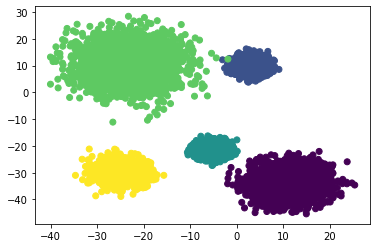

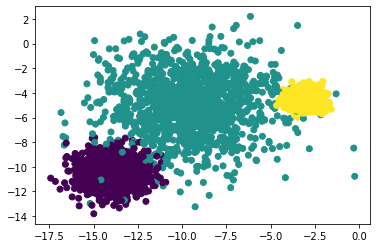

In [33]:
## CREATE BLOBS
# dataset 1
X, y = make_blobs(n_samples=15000, centers=5, cluster_std=[3.9, 1.7, 1.5,5.9, 2.8], n_features=2, random_state=10, center_box =(-35.0, 25.0))
X = np.vstack((X[y == 0][:5000], X[y == 1][:4500], X[y == 2][:4000], X[y == 3][:2000], X[y == 4][:1000]))
y = np.hstack((y[y == 0][:5000], y[y == 1][:4500], y[y == 2][:4000], y[y == 3][:2000], y[y == 4][:1000]))

# dataset 2
X2, y2 = make_blobs(n_samples=3500, cluster_std=[1.0, 2.5, 0.5], random_state=170, center_box =(-15.0, 5.0))

plt.figure(0)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.figure(1)
plt.scatter(X2[:, 0], X2[:, 1], c=y2)

#### Tests: Dataset 1

In [34]:
## TESTING INITIALISATION AND DISTANCE METHODS
D = X
labels_true = y
r = 5
X_hist = []
Y = []

for i in range(0, 6): 
    X_hist.append([])
    Y.append([])
    
# Initialisation: Random, Distance: Euclidean
X_hist[0], Y[0] = k_means(r, D, "Random", "Euclidean")

# Initialisation: Random, Distance: Manhattan
X_hist[1], Y[1] = k_means(r, D, "Random", "Manhattan")

# Initialisation: Forgy, Distance: Euclidean
X_hist[2], Y[2]  = k_means(r, D, "Forgy", "Euclidean")

# Initialisation: Forgy, Distance: Manhattan
X_hist[3], Y[3]  = k_means(r, D, "Forgy", "Manhattan")

# Initialisation: k-means++, Distance: Euclidean
X_hist[4], Y[4]  = k_means(r, D, "++", "Euclidean")

# Initialisation: k-means++, Distance: Manhattan
X_hist[5], Y[5]  = k_means(r, D, "++", "Manhattan")

Running...... done!
Running............ done!
Running........................................................ done!
Running.... done!
Running......................................... done!
Running................... done!


In [35]:
# NMI SCORES
NMI_Scores = []

for method in Y:
    labels_pred = np.empty(len(D))
    clusterIndex = 0
    
    for cluster in method:
        for point in cluster:
            index = point[2]
            labels_pred[index] = clusterIndex

        clusterIndex += 1
        
    NMI_Scores.append(normalized_mutual_info_score(labels_true, labels_pred))

NMI_Scores

/Users/rivamendoza/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/rivamendoza/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/rivamendoza/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/rivamendoza/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will ch

[0.9827375218233748,
 0.8374117838429727,
 0.8720470404658159,
 0.9837678374369271,
 0.8149000709363606,
 0.8656494824061979]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

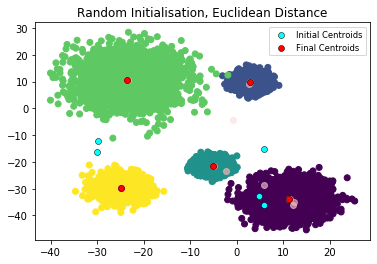

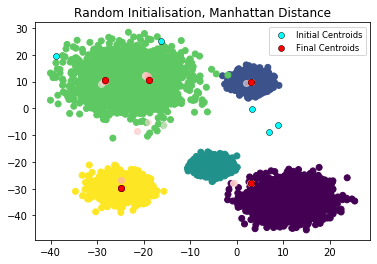

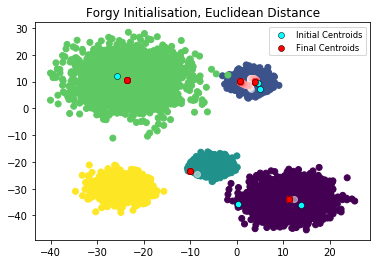

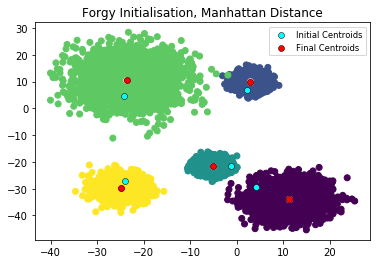

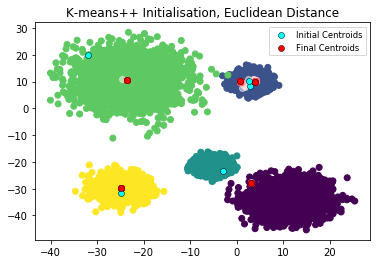

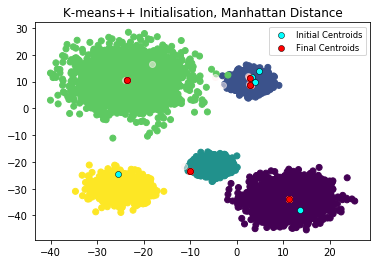

In [36]:
## PLOT OBSERVATIONS
titles = ["Random Initialisation, Euclidean Distance", 
          "Random Initialisation, Manhattan Distance", 
          "Forgy Initialisation, Euclidean Distance",
          "Forgy Initialisation, Manhattan Distance",
          "K-means++ Initialisation, Euclidean Distance",
          "K-means++ Initialisation, Manhattan Distance"]

methodNum = 0

for method in X_hist:
    centroid_x = []
    centroid_y = []
    i = 0

    for centroids in method:
        centroid_x.append([])
        centroid_y.append([])

        for point in centroids:
            centroid_x[i].append(point[0])
            centroid_y[i].append(point[1])
        i += 1

    plt.figure(methodNum)
    
    # plot data points
    plt.scatter(X[:, 0], X[:, 1], c=y)
    
    # plot updated centroids
    for j in range(1, len(centroid_x)-1):
        plt.scatter(centroid_x[j], centroid_y[j], c=mcol.to_rgba(mcol.hsv_to_rgb([0, (j/len(centroid_x)), 1]), 0.5 + j/len(centroid_x) / 2))

    # plot initial centroid
    plt.scatter(centroid_x[0], centroid_y[0], c="aqua", label="Initial Centroids", edgecolor="black", linewidths = "0.5") 

    # plot final centroid
    plt.scatter(centroid_x[-1], centroid_y[-1], c="red", label="Final Centroids", edgecolor="black", linewidths = "0.5")
    plt.title(titles[methodNum])
    plt.legend(loc="best", prop=fontP)
    
    methodNum += 1


#### Tests: Dataset 2 

In [37]:
## TESTING INITIALISATION AND DISTANCE METHODS
D = X2
labels_true = y2
r = 3

X_hist = []
Y = []

for i in range(0, 6): 
    X_hist.append([])
    Y.append([])
    
# Initialisation: Random, Distance: Euclidean
X_hist[0], Y[0] = k_means(r, D, "Random", "Euclidean")

# Initialisation: Random, Distance: Manhattan
X_hist[1], Y[1] = k_means(r, D, "Random", "Manhattan")

# # # Initialisation: Forgy, Distance: Euclidean
X_hist[2], Y[2]  = k_means(r, D, "Forgy", "Euclidean")

# # # Initialisation: Forgy, Distance: Manhattan
X_hist[3], Y[3]  = k_means(r, D, "Forgy", "Manhattan")

# # # Initialisation: k-means++, Distance: Euclidean
X_hist[4], Y[4]  = k_means(r, D, "++", "Euclidean")

# # # Initialisation: k-means++, Distance: Manhattan
X_hist[5], Y[5]  = k_means(r, D, "++", "Manhattan")

Running........ done!
Running........... done!
Running....... done!
Running............ done!
Running..... done!
Running......... done!


In [38]:
# NMI SCORES
NMI_Scores = []

for method in Y:
    labels_pred = np.empty(len(D))
    clusterIndex = 0
    
    for cluster in method:
        for point in cluster:
            index = point[2]
            labels_pred[index] = clusterIndex

        clusterIndex += 1
        
    NMI_Scores.append(normalized_mutual_info_score(labels_true, labels_pred))

NMI_Scores

/Users/rivamendoza/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/rivamendoza/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/rivamendoza/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/rivamendoza/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will ch

[0.7996477365670638,
 0.79541896605368,
 0.7996477365670638,
 0.7954189660536799,
 0.7996477365670638,
 0.7954189660536799]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

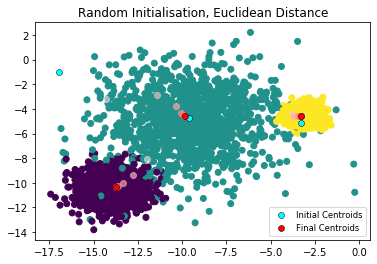

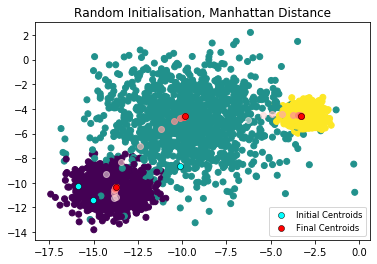

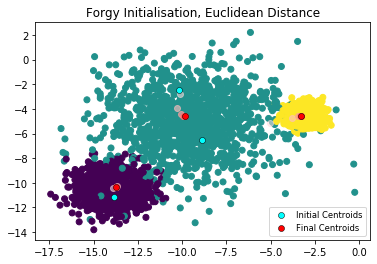

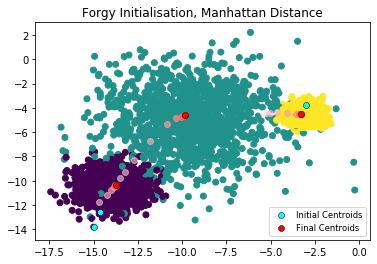

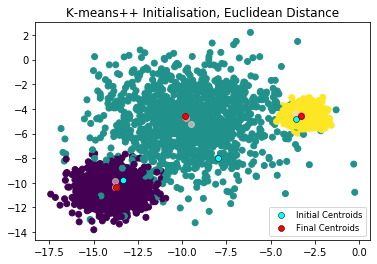

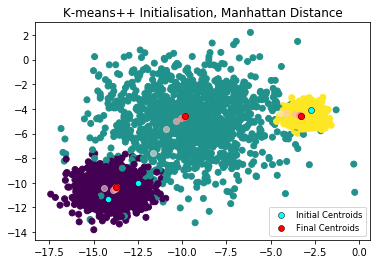

In [39]:
## PLOT OBSERVATIONS
titles = ["Random Initialisation, Euclidean Distance", 
          "Random Initialisation, Manhattan Distance", 
          "Forgy Initialisation, Euclidean Distance",
          "Forgy Initialisation, Manhattan Distance",
          "K-means++ Initialisation, Euclidean Distance",
          "K-means++ Initialisation, Manhattan Distance"]

methodNum = 0

for method in X_hist:
    centroid_x = []
    centroid_y = []
    i = 0

    for centroids in method:
        centroid_x.append([])
        centroid_y.append([])

        for point in centroids:
            centroid_x[i].append(point[0])
            centroid_y[i].append(point[1])
        i += 1

    plt.figure(methodNum)
    
    # plot data points
    plt.scatter(X2[:, 0], X2[:, 1], c=y2)
    
    # plot updated centroids
    for j in range(1, len(centroid_x)-1):
        plt.scatter(centroid_x[j], centroid_y[j], c=mcol.to_rgba(mcol.hsv_to_rgb([0, (j/len(centroid_x)), 1]), 0.5 + j/len(centroid_x) / 2))

    # plot initial centroid
    plt.scatter(centroid_x[0], centroid_y[0], c="aqua", label="Initial Centroids", edgecolor="black", linewidths = "0.5") 

    # plot final centroid
    plt.scatter(centroid_x[-1], centroid_y[-1], c="red", label="Final Centroids", edgecolor="black", linewidths = "0.5")
    plt.title(titles[methodNum])
    plt.legend(loc="best", prop=fontP)
    
    methodNum += 1

## 3. Spectral Clustering

((array([[-0.35949058, -0.37537399],
       [ 0.44358332,  0.88911764],
       [-0.12351365, -0.9717998 ],
       ...,
       [-0.47190856,  0.03826868],
       [ 0.9250681 ,  0.30604529],
       [ 0.96300661, -0.27437357]]), array([1, 0, 0, ..., 1, 0, 0], dtype=int64)), 2)


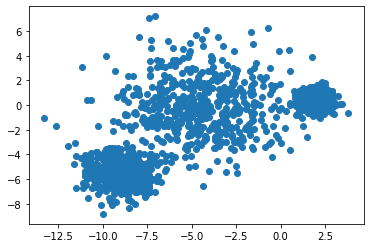

In [594]:
import numpy as np
from sklearn import cluster, datasets, mixture 
from sklearn.neighbors import kneighbors_graph 
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler 
from itertools import cycle, islice
from scipy.sparse import csgraph
from sklearn.manifold import Isomap
from sklearn.pipeline import make_pipeline
import scipy.sparse as sp
import networkx as nx
from sklearn.cluster import SpectralClustering as sc

# ============
# Generate datasets. We choose the size big enough to see the scalability # of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8) 
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state) 
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5],
random_state=random_state)
datasets = [ (noisy_circles,2), (noisy_moons,2) , (varied, 3), (aniso,3) ]

In [808]:
def spectral_clustering(r, D, sim):
    if(sim == "KNN"):
        W = simKNN(D)
    elif(sim == "Eps"):
        W = simEps(D)
    
    L = symLaplacian(W)
    
def simKNN(D, k):
    # returns weighted adjacency matrix of kNN graph
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(D)
    W_ = neigh.kneighbors_graph(D)
    W = nx.from_scipy_sparse_matrix(W_)
    
    return W

def simEps(D,e):
    # returns weighted adjacency matrix of epsilon-neighbourhood graph
    neigh = NearestNeighbors(radius=e)
    neigh.fit(D)
    W_ = neigh.radius_neighbors_graph(D)
    W = nx.from_scipy_sparse_matrix(W_)
    
    return W

def symLaplacian(W):
    return nx.normalized_laplacian_matrix(W)

In [820]:
W_matrix = nx.to_numpy_array(simKNN(aniso[0],600))
s = sc(3, affinity = 'precomputed', n_init=10)
s.fit(W_matrix)
print(normalized_mutual_info_score(s.labels_, varied[1]))

0.6964941250316925


C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.019479327583225167


C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


1.0


C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.6334828792447315


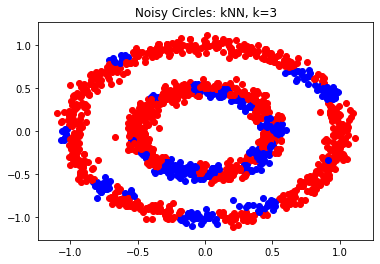

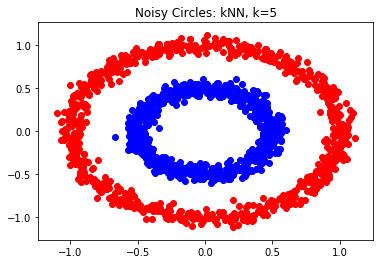

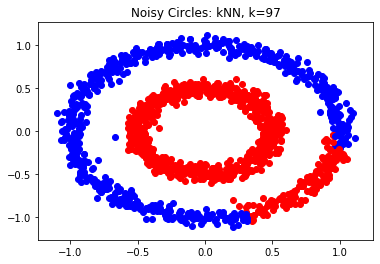

In [778]:
ks = [3, 5, 97]
dataset = noisy_circles

for i in range(0,3):
    W_matrix = nx.to_numpy_array(simKNN(dataset[0], ks[i]))
    s = sc(2, affinity = 'precomputed', n_init=10)
    s.fit(W_matrix)
    print(normalized_mutual_info_score(s.labels_, dataset[1]))
    
    plt.figure()
    
    for j in range(0, len(dataset[1])):
        if(s.labels_[j] == 0):
            plt.scatter(dataset[0][j,0], dataset[0][j,1], c='red')
        elif(s.labels_[j] == 1):
            plt.scatter(dataset[0][j,0], dataset[0][j,1], c='blue')

    plt.title("Noisy Circles: kNN, k=" + str(ks[i]))

C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


4.66446357706852e-15


C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


1.0


C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.9378514145000315


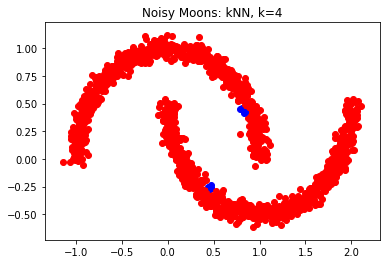

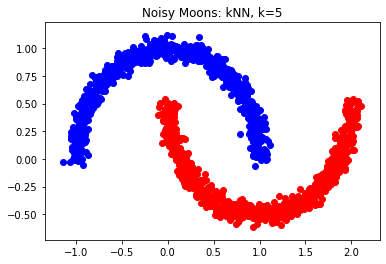

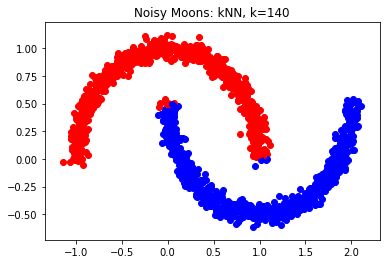

In [790]:
#KNN NOISY MOONS
ks = [4, 5, 140]
dataset = noisy_moons

for i in range(0,3):
    W_matrix = nx.to_numpy_array(simKNN(dataset[0], ks[i]))
    s = sc(2, affinity = 'precomputed', n_init=10)
    s.fit(W_matrix)
    print(normalized_mutual_info_score(s.labels_, dataset[1]))
    
    plt.figure()
    
    for j in range(0, len(dataset[1])):
        if(s.labels_[j] == 0):
            plt.scatter(dataset[0][j,0], dataset[0][j,1], c='red')
        elif(s.labels_[j] == 1):
            plt.scatter(dataset[0][j,0], dataset[0][j,1], c='blue')

    plt.title("Noisy Moons: kNN, k=" + str(ks[i]))

C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.026306929921775652


C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.5311471798493573


C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.9313909700096724


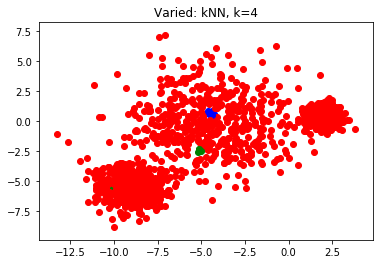

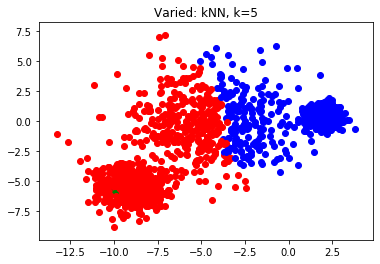

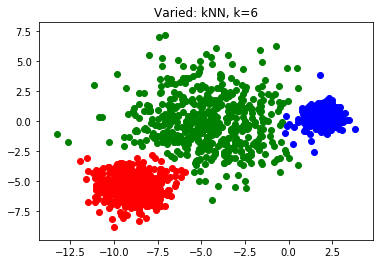

In [792]:
#KNN VARIED
ks = [4, 5, 6]
dataset = varied

for i in range(0,3):
    W_matrix = nx.to_numpy_array(simKNN(dataset[0], ks[i]))
    s = sc(3, affinity = 'precomputed', n_init=10)
    s.fit(W_matrix)
    print(normalized_mutual_info_score(s.labels_, dataset[1]))
    
    plt.figure()
    
    for j in range(0, len(dataset[1])):
        if(s.labels_[j] == 0):
            plt.scatter(dataset[0][j,0], dataset[0][j,1], c='red')
        elif(s.labels_[j] == 1):
            plt.scatter(dataset[0][j,0], dataset[0][j,1], c='blue')
        elif(s.labels_[j] == 2):
            plt.scatter(dataset[0][j,0], dataset[0][j,1], c='green')

    plt.title("Varied: kNN, k=" + str(ks[i]))

C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.7522340428015677


C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.9877083972296619


C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.6225176860463645


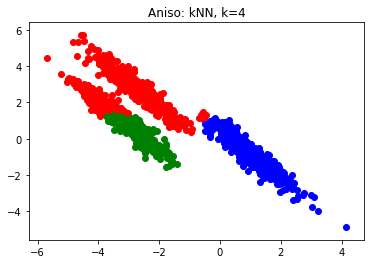

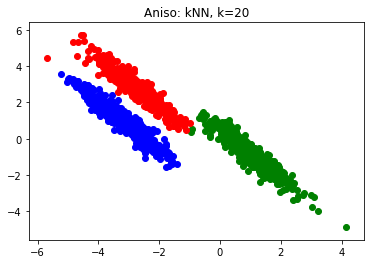

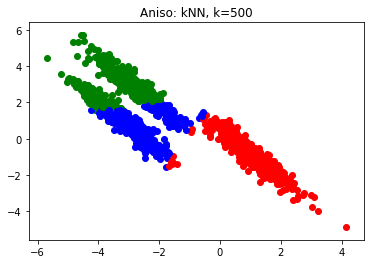

In [806]:
#KNN ANISO
ks = [4, 20, 500]
dataset = aniso

for i in range(0,3):
    W_matrix = nx.to_numpy_array(simKNN(dataset[0], ks[i]))
    s = sc(3, affinity = 'precomputed', n_init=10)
    s.fit(W_matrix)
    print(normalized_mutual_info_score(s.labels_, dataset[1]))
    
    plt.figure()
    
    for j in range(0, len(dataset[1])):
        if(s.labels_[j] == 0):
            plt.scatter(dataset[0][j,0], dataset[0][j,1], c='red')
        elif(s.labels_[j] == 1):
            plt.scatter(dataset[0][j,0], dataset[0][j,1], c='blue')
        elif(s.labels_[j] == 2):
            plt.scatter(dataset[0][j,0], dataset[0][j,1], c='green')

    plt.title("Aniso: kNN, k=" + str(ks[i]))

C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.011024009875915387


C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


1.0


C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.0832550540344152


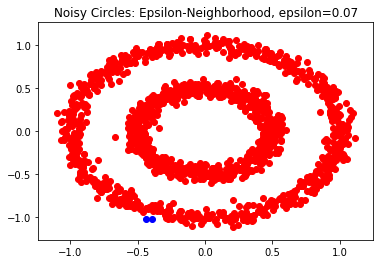

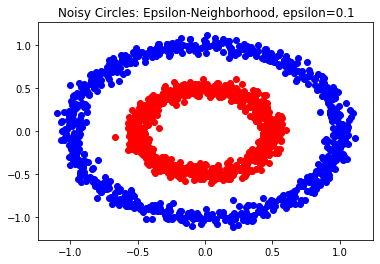

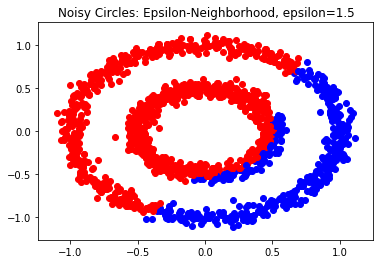

In [809]:
#EPS NOISY CIRCLES
e = [0.07, 0.1, 1.5]
dataset = noisy_circles

for i in range(0,3):
    W_matrix = nx.to_numpy_array(simEps(dataset[0], e[i]))
    s = sc(2, affinity = 'precomputed', n_init=10)
    s.fit(W_matrix)
    print(normalized_mutual_info_score(s.labels_, dataset[1]))
    
    plt.figure()
    
    for j in range(0, len(dataset[1])):
        if(s.labels_[j] == 0):
            plt.scatter(dataset[0][j,0], dataset[0][j,1], c='red')
        elif(s.labels_[j] == 1):
            plt.scatter(dataset[0][j,0], dataset[0][j,1], c='blue')

    plt.title("Noisy Circles: Epsilon-Neighborhood, epsilon=" + str(e[i]))

C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.0016915653623456948


C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.9866753790064572


C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.9572159171233204


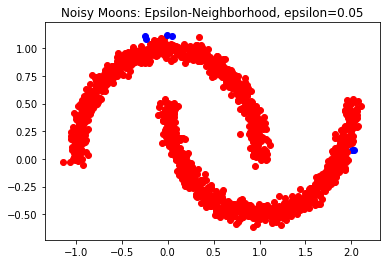

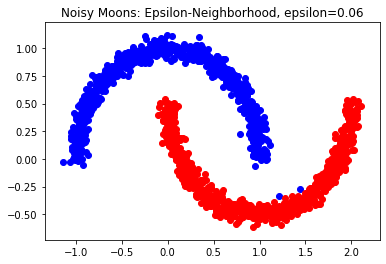

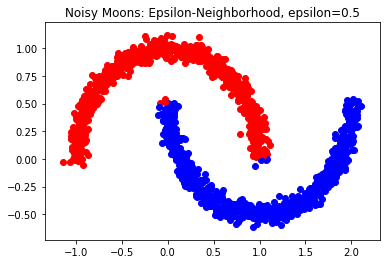

In [810]:
#EPS NOISY MOONS
e = [0.05, 0.06, 0.5]
dataset = noisy_moons

for i in range(0,3):
    W_matrix = nx.to_numpy_array(simEps(dataset[0], e[i]))
    s = sc(2, affinity = 'precomputed', n_init=10)
    s.fit(W_matrix)
    print(normalized_mutual_info_score(s.labels_, dataset[1]))
    
    plt.figure()
    
    for j in range(0, len(dataset[1])):
        if(s.labels_[j] == 0):
            plt.scatter(dataset[0][j,0], dataset[0][j,1], c='red')
        elif(s.labels_[j] == 1):
            plt.scatter(dataset[0][j,0], dataset[0][j,1], c='blue')

    plt.title("Noisy Moons: Epsilon-Neighborhood, epsilon=" + str(e[i]))

C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.022351077770596955


C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.9043435780787134


C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.749369305273204


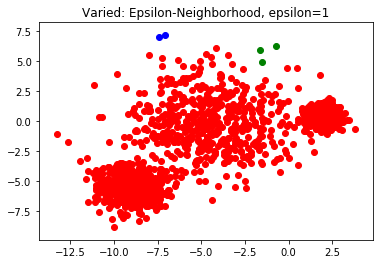

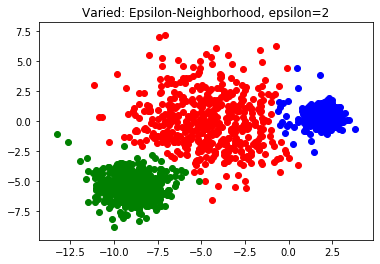

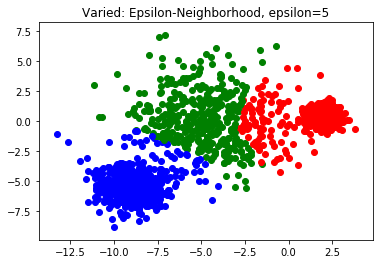

In [812]:
#EPS VARIED
e = [1, 2, 5]
dataset = varied

for i in range(0,3):
    W_matrix = nx.to_numpy_array(simEps(dataset[0], e[i]))
    s = sc(3, affinity = 'precomputed', n_init=10)
    s.fit(W_matrix)
    print(normalized_mutual_info_score(s.labels_, dataset[1]))
    
    plt.figure()
    
    for j in range(0, len(dataset[1])):
        if(s.labels_[j] == 0):
            plt.scatter(dataset[0][j,0], dataset[0][j,1], c='red')
        elif(s.labels_[j] == 1):
            plt.scatter(dataset[0][j,0], dataset[0][j,1], c='blue')        
        elif(s.labels_[j] == 2):
            plt.scatter(dataset[0][j,0], dataset[0][j,1], c='green')

    plt.title("Varied: Epsilon-Neighborhood, epsilon=" + str(e[i]))

C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.0004702566025970537


C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.9912433535368305


C:\Users\vramu\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.008923591305866686


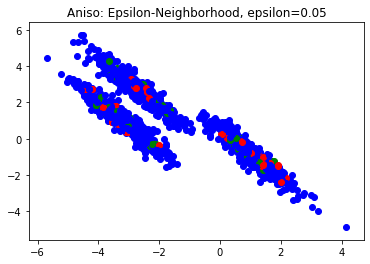

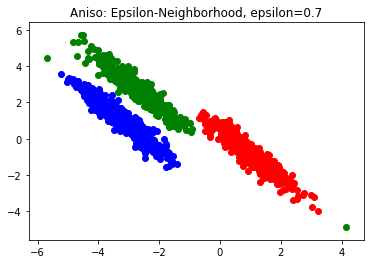

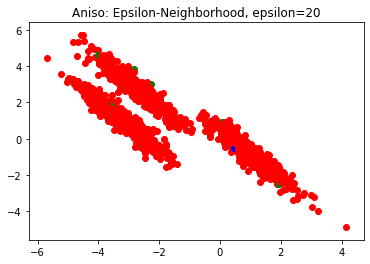

In [817]:
#EPS ANISO
e = [0.05, 0.7, 20]
dataset = aniso

for i in range(0,3):
    W_matrix = nx.to_numpy_array(simEps(dataset[0], e[i]))
    s = sc(3, affinity = 'precomputed', n_init=10)
    s.fit(W_matrix)
    print(normalized_mutual_info_score(s.labels_, dataset[1]))
    
    plt.figure()
    
    for j in range(0, len(dataset[1])):
        if(s.labels_[j] == 0):
            plt.scatter(dataset[0][j,0], dataset[0][j,1], c='red')
        elif(s.labels_[j] == 1):
            plt.scatter(dataset[0][j,0], dataset[0][j,1], c='blue')
        elif(s.labels_[j] == 2):
            plt.scatter(dataset[0][j,0], dataset[0][j,1], c='green')

    plt.title("Aniso: Epsilon-Neighborhood, epsilon=" + str(e[i]))